# Train Notebook

This notebook trains a RandomForestRegressor using the processed data produced by `prepare.py`.
It explains each step, shows key shapes, and saves the trained model plus feature names.


## 1) Load configuration & resolve paths
We search upward for `params.yaml` so the notebook works from `notebooks/`.

In [1]:

from pathlib import Path
import os, json
import pandas as pd
import yaml

# Locate the repo root by searching upward for params.yaml
def find_repo_root(start: Path | None = None) -> Path:
    cur = (start or Path.cwd()).resolve()
    for _ in range(10):
        if (cur / "params.yaml").exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise FileNotFoundError("Could not find 'params.yaml' in parent directories. Start this notebook from your repo.")

ROOT = find_repo_root(Path.cwd())
print(f'Resolved ROOT: {ROOT}')
PARAMS_PATH = ROOT / "params.yaml"

with open(PARAMS_PATH, "r") as f:
    params = yaml.safe_load(f)

DATA_DIR = ROOT / "data"
PROCESSED = DATA_DIR / "processed"
MODELS = ROOT / "models"
REPORTS = ROOT / "reports"
PROCESSED.mkdir(parents=True, exist_ok=True)
MODELS.mkdir(parents=True, exist_ok=True)
REPORTS.mkdir(parents=True, exist_ok=True)

display(params)


Resolved ROOT: /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies


{'data': {'raw_csv': 'data/raw/insurance_dataset.csv',
  'target': 'Claim_Amount',
  'test_size': 0.2,
  'random_state': 42},
 'model': {'n_estimators': 200,
  'max_depth': 12,
  'n_jobs': -1,
  'random_state': 42}}

## 2) Load processed datasets
We load `X_train.csv`, `X_test.csv`, `y_train.csv`, `y_test.csv` from `data/processed/`.
If the lengths mismatch, the notebook will raise a clear error.

In [2]:

# Load processed data
X_train = pd.read_csv(PROCESSED / "X_train.csv")
X_test  = pd.read_csv(PROCESSED / "X_test.csv")

def read_y(path: Path, n_expected: int) -> pd.Series:
    y = pd.read_csv(path).iloc[:, 0]
    if len(y) == n_expected:
        return y
    y2 = pd.read_csv(path, header=None).iloc[:, 0]
    if len(y2) == n_expected:
        return y2
    raise ValueError(f"Inconsistent length when reading {path}: got {len(y)} (header) and {len(y2)} (no header), expected {n_expected}.")

y_train = read_y(PROCESSED / "y_train.csv", len(X_train))
y_test  = read_y(PROCESSED / "y_test.csv", len(X_test))

print("Shapes:")
print(" X_train:", X_train.shape, " X_test:", X_test.shape)
print(" y_train:", y_train.shape, " y_test:", y_test.shape)

display(X_train.head(5))


Shapes:
 X_train: (10400, 10)  X_test: (2600, 10)
 y_train: (10400,)  y_test: (2600,)


,Age,Income,Gender_Male,Marital_Status_Single,Education_Master's,Education_PhD,Occupation_Doctor,Occupation_Engineer,Occupation_Teacher,Occupation_Waiter
0,46.0,296112.0,False,False,False,True,False,False,False,False
1,65.0,274007.0,False,True,True,False,False,False,True,False
2,56.0,48050.0,True,False,False,False,False,True,False,False
3,59.0,174748.0,False,False,False,True,False,False,False,False
4,51.0,246132.0,False,False,True,False,False,False,False,False


## 3) Configure and train the model
We use parameters from `params.yaml` under the `model:` section.

In [3]:

from sklearn.ensemble import RandomForestRegressor

model_cfg = params.get("model", {}) or {}
n_estimators = int(model_cfg.get("n_estimators", 200))
max_depth = model_cfg.get("max_depth", None)
max_depth = None if (max_depth in (None, "None")) else int(max_depth)
n_jobs = int(model_cfg.get("n_jobs", -1))
random_state = int(model_cfg.get("random_state", 42))

rf = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    n_jobs=n_jobs,
    random_state=random_state,
)
rf.fit(X_train, y_train)

print("Model trained.")


Model trained.


## 4) Save artifacts
We save the model to `models/model.joblib` and the feature names to `models/feature_names.json`.

In [4]:

from joblib import dump
feature_names = list(X_train.columns)

model_path = MODELS / "model.joblib"
dump(rf, model_path)

(MODELS / "feature_names.json").write_text(json.dumps(feature_names, indent=2))

print(f"Saved model to: {model_path}")
print(f"Saved feature names to: {MODELS / 'feature_names.json'}")


Saved model to: /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies/models/model.joblib
Saved feature names to: /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies/models/feature_names.json


## 5) Quick sanity visual (optional)
Basic bar chart of top feature importances. If the model has no `feature_importances_`, the cell will skip plotting.

Top 10 feature importances:


,importance
Income,0.468303
Age,0.209141
Occupation_Waiter,0.054896
Occupation_Doctor,0.053485
Occupation_Engineer,0.053266
Occupation_Teacher,0.047184
Gender_Male,0.033059
Marital_Status_Single,0.032488
Education_Master's,0.027757
Education_PhD,0.020421


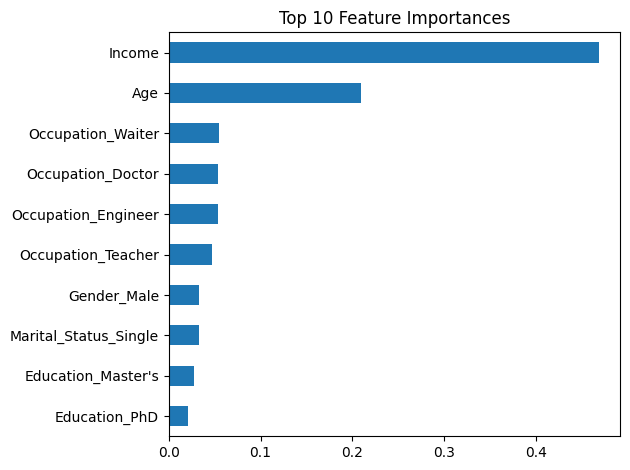

In [5]:

import matplotlib.pyplot as plt

if hasattr(rf, "feature_importances_"):
    importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False).head(10)
    print("Top 10 feature importances:")
    display(importances.to_frame("importance"))
    plt.figure()
    importances.sort_values().plot(kind="barh")
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()
else:
    print("Model has no feature_importances_. Skipping plot.")
